# Exercise 2
## Céline Budding && Dorothea Müller

# Configurations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eig

%matplotlib inline

from helper import gaussian_spectrum_1D

# 1. Slow Feature Analysis on two independent signals

## 1.

In [2]:
def generate_random_signal(T, e):
    v = np.random.random(T)
    v_filtered = gaussian_spectrum_1D(v, e)
    
    return v_filtered

## 2.

In [3]:
def generate_signals_different_tau(all_tau, T):
    X = np.zeros(shape = (len(all_tau), T))

    for i, tau in enumerate(all_tau):
        eps = 1/tau**2
        signal = generate_random_signal(T, eps)
        # Zero mean.
        signal = signal - np.mean(signal)
        # Unit variance.
        signal /= np.std(signal)
        
        X[i] = signal
        
    return X

In [4]:
T = 1000
all_tau = [30, 100]

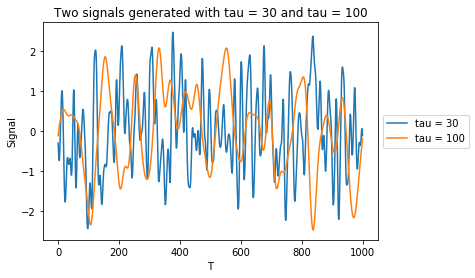

In [5]:
X = generate_signals_different_tau(all_tau, T)

for i, x in enumerate(X):
    plt.plot(x, label = f"tau = {all_tau[i]}")

plt.xlabel("T")
plt.ylabel("Signal")
plt.title('Two signals generated with tau = 30 and tau = 100')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**How does τ influence the characteristics of the signals?**

A higher tau leads to a lower frequency in the data, so a slower signal. 

## 3. Linear SFA

In [6]:
def calculate_eigvec(X):
    # Joint covariance matrix.
    C = np.cov(X)
    C_derivative = np.diff(X) @ np.diff(X).T / (T-1)
    # C is right-hand side matrix in the generalized eigenvalue problem, so is second parameter.
    eigval, eigvec = eig(C_derivative, C)
    
    return eigvec, eigval

In [7]:
eigvec, _ = calculate_eigvec(X)

The function eig of the scipy package returns already normalized eigenvectors according to the documentation (see returned values in  https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html), so there is no need to normalize.

In [8]:
# To prove the documentation is correct:
for i in range(eigvec.shape[0]):
    print(np.linalg.norm(eigvec[:, i]))

1.0
1.0


# 4. 

In [9]:
eigvec

array([[-0.99461149, -0.00152312],
       [-0.10367251,  0.99999884]])

**What kind of mixture do you ideally expect given how the data was generated?**

The signals have been generated independently, so we would expect very little mixing.

**What does the empirical mixture look like, judging from the extracted eigenvectors?**

For each eigenvector, we see that there is one large component and one small component, indicating that both eigenvectors represent only one signal (the first and second respectively), and there is no or very little mixing, as expected before. 

## 5.

In [10]:
sample_sizes = np.logspace(1, 4, num=20)
sample_sizes = [int(s) for s in sample_sizes]

In [11]:
def linear_SFA(sample_sizes, all_tau):
    eigvecs_for_sample_sizes = []
    eigvals_for_sample_sizes = []
    
    for sample_size in sample_sizes:
        X = generate_signals_different_tau(all_tau, sample_size)
        eigvec, eigval = calculate_eigvec(X)
        eigvecs_for_sample_sizes.append(eigvec)
        eigvals_for_sample_sizes.append(eigval)
        
    return eigvecs_for_sample_sizes, eigvals_for_sample_sizes

In [12]:
eigvecs, eigvals = linear_SFA(sample_sizes, all_tau)

In [13]:
print(len(eigvecs))

20


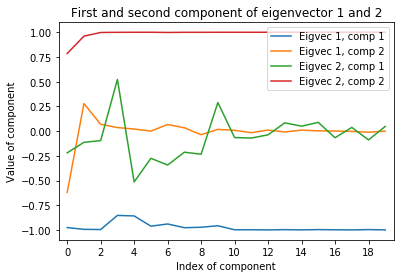

In [14]:
eigvecs = np.array(eigvecs)

plt.plot(eigvecs[:, 0, 0], label = 'Eigvec 1, comp 1')
plt.plot(eigvecs[:, 0, 1], label = 'Eigvec 1, comp 2')
plt.plot(eigvecs[:, 1, 0], label = 'Eigvec 2, comp 1')
plt.plot(eigvecs[:, 1, 1], label = 'Eigvec 2, comp 2')
plt.title("First and second component of eigenvector 1 and 2")
plt.xlabel('Index of component')
plt.ylabel('Value of component')
plt.xticks(np.arange(0, 20, step=2))
plt.xlim(-0.5, 19.5)
plt.legend()
plt.show()

**How does the SFA-mixture change depending on the length of the input signal?**

For larger sample size, the components of the eigenvectors indicate that only one signal is represented in each of the eigenvectors (one component with a high value, the other around 0). For short sequences, the values overlap more and there is more mixing. In general, there is less mixing, the longer the sequence gets. 

**Can you give an intuition why?**
For short signal sequences, there is a higher chance to get temporally correlated signals by chance (which would lead to mixing of the signals). This is reduced with increasing length of the sequence. 

## 6.

In [15]:
eigvals = np.array(eigvals)
# Choose last one to have large sample size and small numerical errors.
eigval = eigvals[-1, :]
eigval

array([0.4231129 +0.j, 0.04051498+0.j])

**How do the eigenvalues depend on the τ ’s that you chose?**

The τ = 30 results in a larger eigenvalue than τ = 100. As we are taking eigenvectors that correspond to a small eigenvalue, this is in accordance with the results above. This also means that if the taus are similar, the eigenvalues will be similar and we cannot properly separate the signal. 

# 2. SFA on a high-dimensional correlated signal

## 1.

In [16]:
L = 10000
e = 0.04
signal = generate_random_signal(L, e)
len_receptive_field = 100

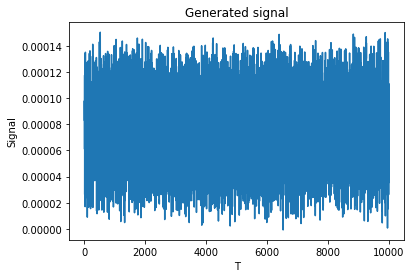

In [17]:
plt.plot(signal)
plt.xlabel('T')
plt.ylabel('Signal')
plt.title('Generated signal')
plt.show()

## 2.

In [18]:
def extract_receptive_fields(stimulus, len_receptive_field):
    number_fields = len(stimulus) - len_receptive_field
    all_rec_fields = np.zeros(shape = (number_fields, len_receptive_field))
    
    for i in range(number_fields):
        all_rec_fields[i] = stimulus[i:len_receptive_field+i]
    
    # Enforce zero mean across each field.
    all_rec_fields -= np.mean(all_rec_fields.T, axis = 1)
    all_rec_fields = all_rec_fields.T
    
    return all_rec_fields

In [19]:
X = extract_receptive_fields(signal, len_receptive_field)

## 3.

In [20]:
# Joint covariance matrix.
C = np.cov(X)
X_dot = np.diff(X, axis = 1)
C_derivative = X_dot @ X_dot.T / (L-1)
# C is right-hand side matrix in the generalized eigenvalue problem, so is second parameter.
eigval, eigvec = eig(C_derivative, C)

In [21]:
# Sort in ascending order.
idx = np.argsort(np.abs(eigval))
eigvec = eigvec[:, idx]
eigval = eigval[idx]

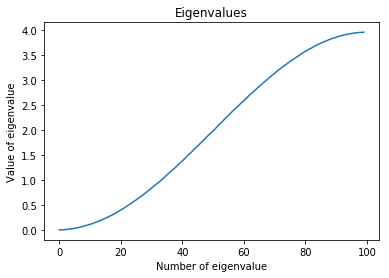

In [22]:
plt.plot(eigval.real)
plt.xlabel('Number of eigenvalue')
plt.ylabel('Value of eigenvalue')
plt.title('Eigenvalues')
plt.show()

In [23]:
# Select the first five smallest eigenvectors
five_eigvec = eigvec[:, :5]

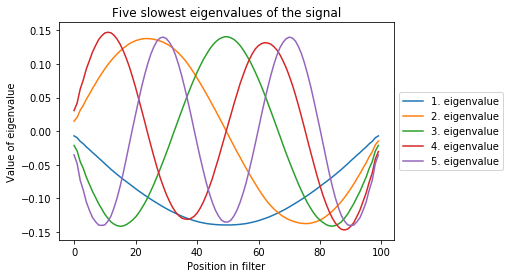

In [24]:
for i, eig_vec in enumerate(five_eigvec.T): 
    plt.plot(eig_vec, label = '{}. eigenvalue'.format(i+1))
plt.xlabel('Position in filter')
plt.ylabel('Value of eigenvalue')
plt.title('Five slowest eigenvalues of the signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 5. 

**How do you interpret the shape of the eigenvectors?**
The eigenvectors are periodic and they remind us of a sinusoidal grating, so we could interpret them as spatial or temporal receptive fields.  

**In which way do the characteristics of the eigenvectors correspond to the intentions underlying SFA?**
We do want to have only small changes regarding g(x), and we can see that these are very low frequency signals.  

**Discuss the properties of the eigenvectors at the boundaries of the receptive fields (Hint: think about how these boundaries react when sliding over edges in the image).**
At the edges, we would expect a fast change in the signal. However, these eigenvectors model for small changes, so their input at the edges is not relevant for the response of the neuron, so the edges get weight 0. 

**How does the shape of these eigenvectors relate to the structure of the receptive fields in primary visual cortex V1?**
As mentioned in the first question, these signals remind us of a sinusoidal grating. We know that the receptive fields in the primary visual cortex can be modeled by a Gabor function, which is fairly similar to what we see here. 

## 6.

In [25]:
y = five_eigvec.T @ X

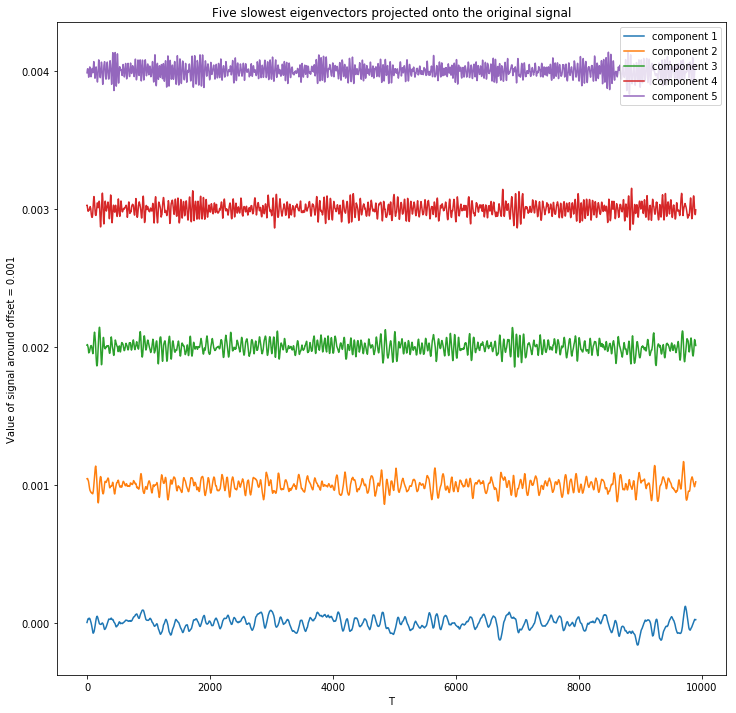

In [26]:
offset = 0.001
plt.figure(figsize = (12,12))
for i, y_ in enumerate(y):
    plt.plot(y_ + i * offset, label = f"component {i + 1}")

plt.xlabel('T')
plt.ylabel('Value of signal around offset = 0.001')
plt.title('Five slowest eigenvectors projected onto the original signal')
plt.legend()
plt.show()

**Did the *Slow* Feature Analysis succeed?**

The components do not change over time (and definitely less than the original signal), so it would suggest that it worked.